<a href="https://colab.research.google.com/github/ekqlsrla/ESAA-2/blob/main/HW/1209_Tensorflow_CH04_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **파이썬 딥러닝 텐서플로**
 ---

## **| 04** 위성 이미지 분류

### 4-1 텐서플로 데이터셋 로드

* EuroSAT Dataset : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 데이터

In [9]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

import tensorflow_datasets as tfds

In [ ]:
#데이터 셋 로드

DATA_DIR = "dataset/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split = ['train[:80%]', 'train[80%:]'],
                                                               shuffle_files = True,
                                                               as_supervised = True,
                                                               with_info = True,
                                                               data_dir = DATA_DIR)

print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incompleteUJNP1U/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

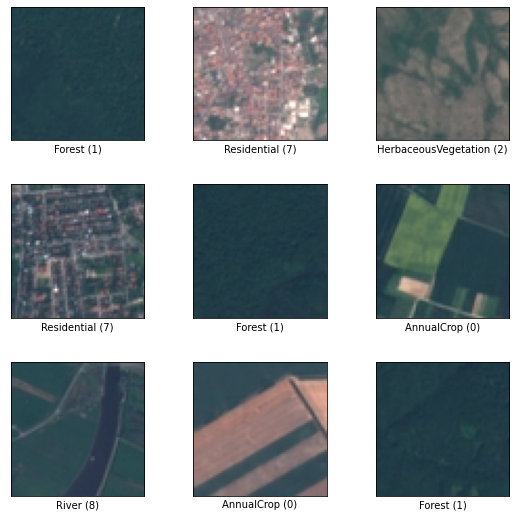

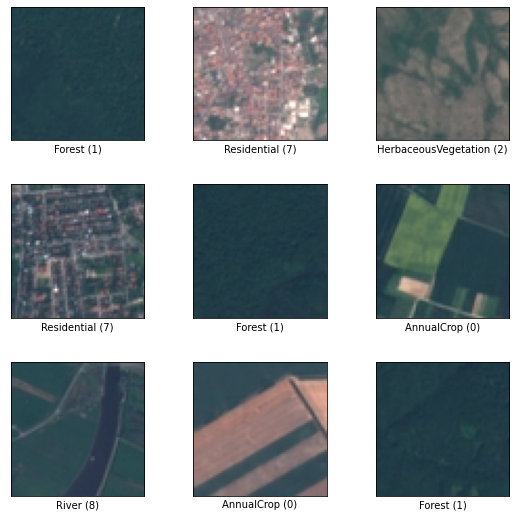

In [ ]:
#데이터 확인

tfds.show_examples(train_ds,info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
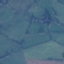
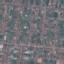
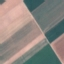
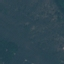
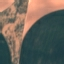
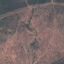
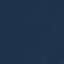
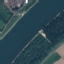
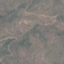
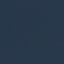

In [ ]:
tfds.as_dataframe(valid_ds.take(10),info)

In [ ]:
#목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [ ]:
#숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2 데이터 전처리

* `num_parallel_calls` : 전처리 처리 과정을 **오토튠**으로 지정

In [ ]:
BATCH_SIZE= 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    #정규화, float32 변환
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls= tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3 모델 훈련 및 검증

* 배치 정규화/ 합성곱 / 풀링 레이어로 구성된 유닛 2개 연결 후 Dense 레이어와 Dropout으로 구성된 분류기

In [ ]:
def build_model() :
  model = tf.keras.Sequential([
      
      #Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

  ])
  return model

model = build_model()

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_data, validation_data = valid_data, epochs = 50)

Epoch 1/50
338/338 [==============================] - 170s 500ms/step - loss: 1.6224 - accuracy: 0.4439 - val_loss: 1.7022 - val_accuracy: 0.4226
Epoch 2/50
338/338 [==============================] - 209s 619ms/step - loss: 1.2663 - accuracy: 0.5662 - val_loss: 0.8885 - val_accuracy: 0.7124
Epoch 3/50
338/338 [==============================] - 238s 706ms/step - loss: 1.0633 - accuracy: 0.6270 - val_loss: 0.8017 - val_accuracy: 0.7306
Epoch 4/50
338/338 [==============================] - 245s 723ms/step - loss: 0.9363 - accuracy: 0.6728 - val_loss: 0.6988 - val_accuracy: 0.7733
Epoch 5/50
338/338 [==============================] - 161s 477ms/step - loss: 0.8297 - accuracy: 0.7129 - val_loss: 0.5994 - val_accuracy: 0.8174
Epoch 6/50
338/338 [==============================] - 161s 477ms/step - loss: 0.7519 - accuracy: 0.7416 - val_loss: 0.5236 - val_accuracy: 0.8415
Epoch 7/50
338/338 [==============================] - 192s 569ms/step - loss: 0.6744 - accuracy: 0.7701 - val_loss: 0.5732 -

In [19]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

* 검증 셋에 대한 손실함수 줄어들지 않음 -> **과대 적합 경향**

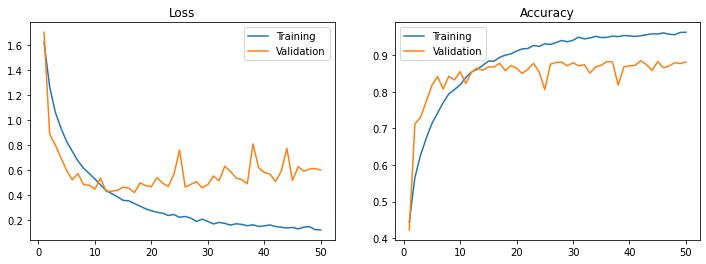

In [ ]:
plot_loss_acc(history,50)

### 4-4 데이터 증강(Data Augmentation)

* 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능 확보하는 기법

Text(0.5, 1.0, 'SeaLake')

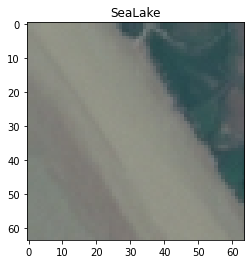

In [ ]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [ ]:
#데이터 증강 전후비교

def plot_augmentation(original, augmented) :
  fig,axes = plt.subplots(1,2, figsize = (12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')
  
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

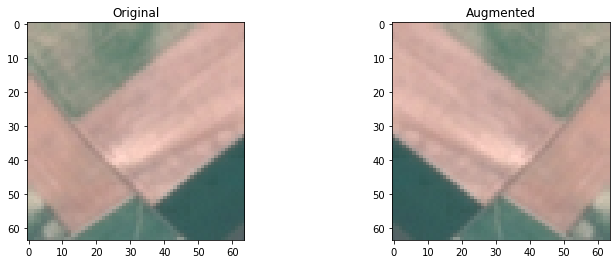

In [ ]:
#좌우 뒤집기

lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image,lr_flip)

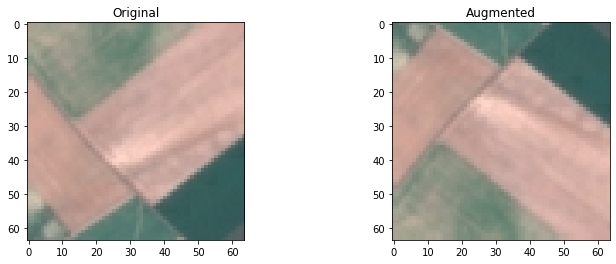

In [ ]:
#상하뒤집기

ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

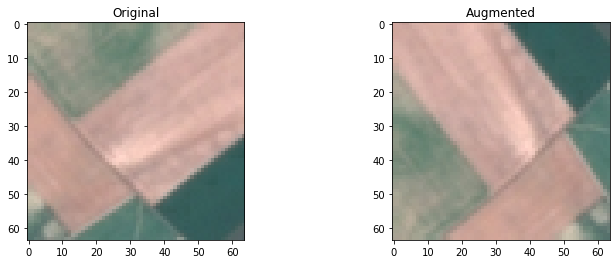

In [ ]:
#반시계 방향 90도 회전

rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

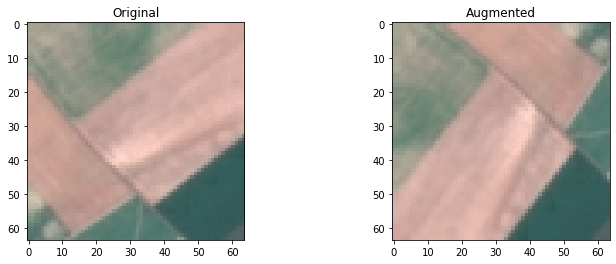

In [ ]:
#행렬의 도치 Transpose

transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

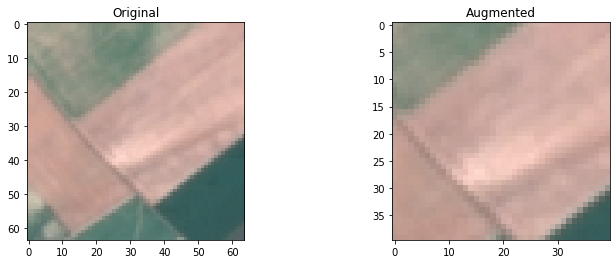

In [ ]:
#이미지 자르기
crop1 = tf.image.central_crop(image,central_fraction = 0.6)
plot_augmentation(image, crop1)

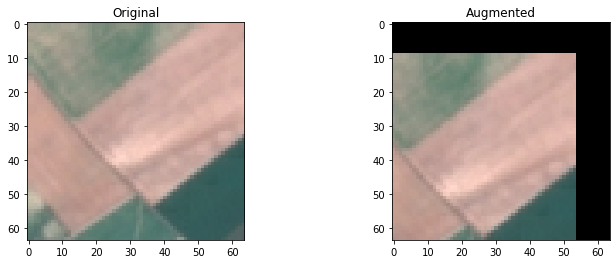

In [ ]:
#원본 이미지의 크기를 키우고 이미지를 원본 크기와 같게 자르면 이미지가 랜덤한 방향으로 시프트 

img = tf.image.resize_with_crop_or_pad(image, 64+20,64+20)
crop2 = tf.image.random_crop(img,size = [64,64,3])
plot_augmentation(image, crop2)

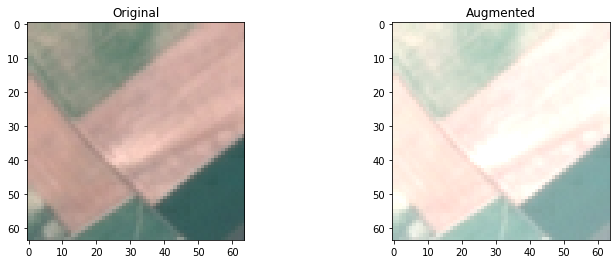

In [ ]:
#이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta = 0.3)
plot_augmentation(image, brightness)

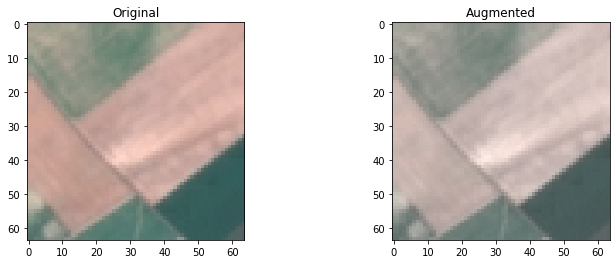

In [ ]:
#이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor = 0.5)
plot_augmentation(image, saturation)

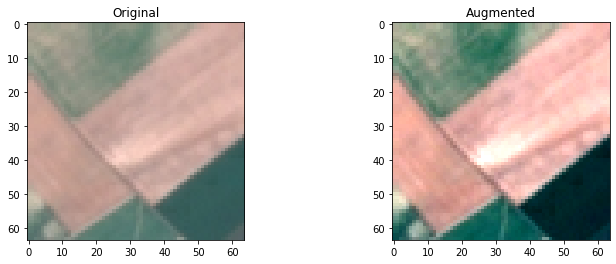

In [ ]:
#이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor = 2)
plot_augmentation(image, contrast)

In [ ]:

# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)
     

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:

# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)      
     
#데이터 증강 전후 성능 차이는 크게 없음

Epoch 1/50
338/338 [==============================] - 185s 542ms/step - loss: 1.9504 - accuracy: 0.2663 - val_loss: 1.9150 - val_accuracy: 0.3183
Epoch 2/50
338/338 [==============================] - 181s 536ms/step - loss: 1.6126 - accuracy: 0.3642 - val_loss: 1.3536 - val_accuracy: 0.4789
Epoch 3/50
338/338 [==============================] - 178s 527ms/step - loss: 1.4941 - accuracy: 0.4256 - val_loss: 1.2481 - val_accuracy: 0.5526
Epoch 4/50
338/338 [==============================] - 177s 523ms/step - loss: 1.3927 - accuracy: 0.4719 - val_loss: 1.2187 - val_accuracy: 0.5657
Epoch 5/50
338/338 [==============================] - 184s 543ms/step - loss: 1.3095 - accuracy: 0.5133 - val_loss: 1.0861 - val_accuracy: 0.6163
Epoch 6/50
338/338 [==============================] - 178s 526ms/step - loss: 1.2326 - accuracy: 0.5502 - val_loss: 1.0118 - val_accuracy: 0.6433
Epoch 7/50
338/338 [==============================] - 182s 539ms/step - loss: 1.1706 - accuracy: 0.5749 - val_loss: 0.9281 -

In [ ]:
plot_loss_acc(aug_history,50)

### 4-5 ResNet 사전 학습 모델

* **사전에** 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top층에 위성 이미지를 분류할 수 있는 **최종 분류기 추가**하는 방식 -> `전이학습`

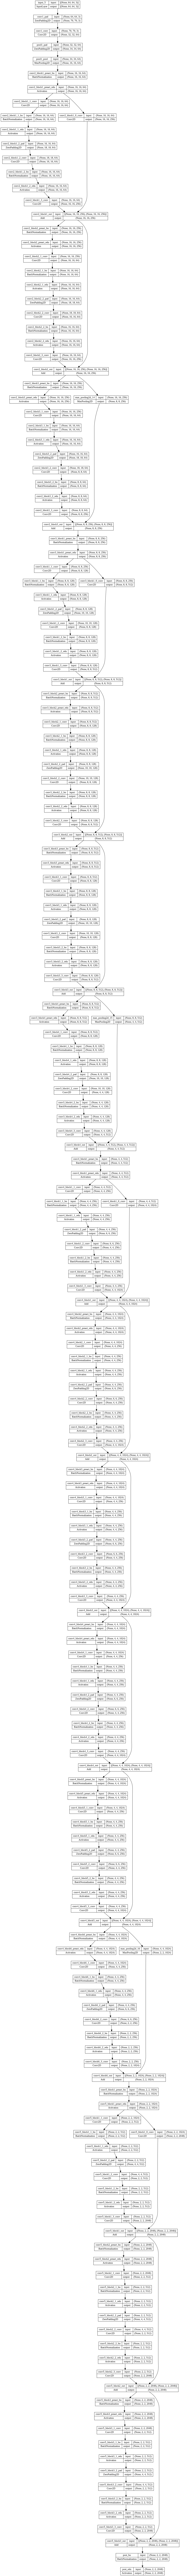

In [ ]:
#Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기

from tensorflow.keras.applications.resnet_v2 import ResNet50V2

pre_trained_base = ResNet50V2(include_top = False, weights = 'imagenet',
                              input_shape = [64,64,3])

#가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

#모델 구조 시각화
from keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes = True, show_layer_names = True)

In [ ]:
#Top 충에 Classifier 추가

def build_trainsfer_classifier() :
  model = tf.keras.Sequential([
      pre_trained_base,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64,activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
  ])
  return model

#모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [ ]:
#모델 컴파일
tc_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

#모델 훈련
tc_history = tc_model.fit(train_aug, validation_data = valid_aug, epochs = 50)

Epoch 1/50
338/338 [==============================] - 336s 975ms/step - loss: 1.0282 - accuracy: 0.6703 - val_loss: 0.5859 - val_accuracy: 0.8033
Epoch 2/50
338/338 [==============================] - 329s 974ms/step - loss: 0.7237 - accuracy: 0.7736 - val_loss: 0.5078 - val_accuracy: 0.8256
Epoch 3/50
338/338 [==============================] - 334s 988ms/step - loss: 0.6442 - accuracy: 0.7916 - val_loss: 0.4861 - val_accuracy: 0.8370
Epoch 4/50
338/338 [==============================] - 330s 975ms/step - loss: 0.6033 - accuracy: 0.8057 - val_loss: 0.4753 - val_accuracy: 0.8409
Epoch 5/50
338/338 [==============================] - 330s 977ms/step - loss: 0.5702 - accuracy: 0.8145 - val_loss: 0.4626 - val_accuracy: 0.8443
Epoch 6/50
338/338 [==============================] - 328s 970ms/step - loss: 0.5414 - accuracy: 0.8245 - val_loss: 0.4337 - val_accuracy: 0.8522
Epoch 7/50
338/338 [==============================] - 332s 982ms/step - loss: 0.5244 - accuracy: 0.8283 - val_loss: 0.4415 -

In [ ]:
plot_loss_acc(tc_history,50)

---
## **| 05** 개/고양이 분류

### 5-1 분석 준비

#### 라이브러리 불러오기

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt


#### 압축 파일 해제


In [11]:
#압축 해제
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + 'Colab Notebooks/ESAA-2/DATA/cat and dog/cat-and-dog.zip'

#저장 경로
extract_folder = 'Colab Notebooks/ESAA-2/DATA/cat and dog/'

import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [12]:
#훈련 셋, 검증 셋 위치 지정
train_dir = extract_folder + 'training_set/training_set'
valid_dir = extract_folder + 'test_set/test_set'

### 5-2 모델 학습

#### ImageDataGenerator

In [13]:
image_gen = ImageDataGenerator(rescale = (1/255.))
image_gen

#### flow_from_directory 함수

* 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋 처리

In [14]:
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size = 32,
                                          target_size = (224,224),
                                          classes = ['cats','dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)

valid_gen = image_gen.flow_from_directory(valid_dir, 
                                          batch_size = 32, target_size = (224,224),
                                          classes = ['cats','dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-6-091bcacd97f0>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


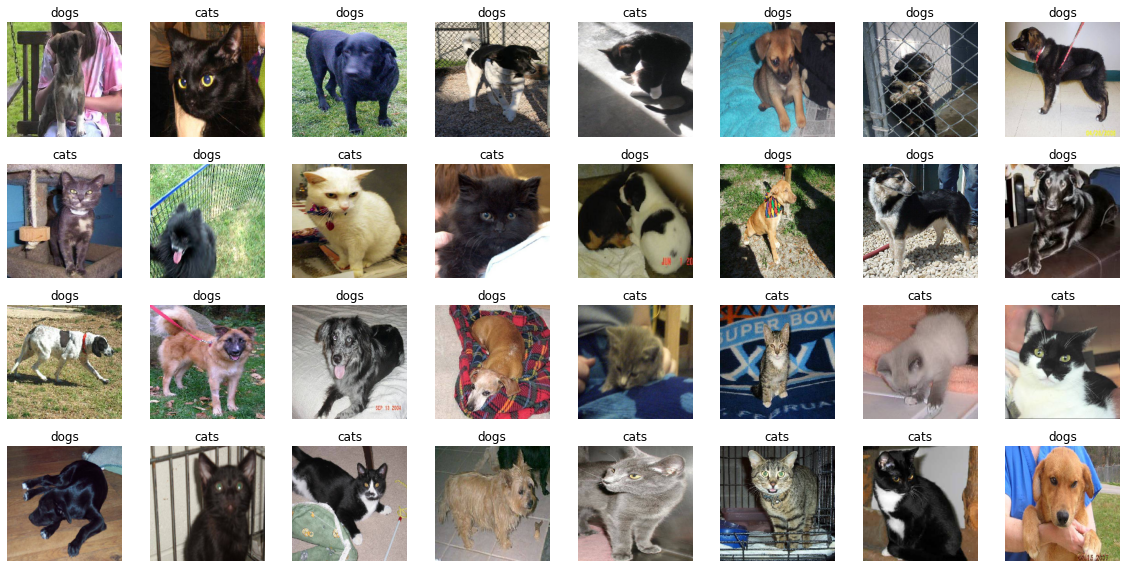

In [ ]:
#샘플 이미지 출력

class_labels = ['cats','dogs']
batch = next(train_gen)
images, labels = batch[0],batch[1]

plt.figure(figsize = (16,8))
for i in range(32) :
  ax = plt.subplot(4,8,i+1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis('off')

plt.tight_layout()
plt.show()

#### 모델 훈련

* **배치 정규화 - 합성곱 - 풀링** 으로 구성된 단위블럭 3개 반복
* 최종 분류기 : Dense 레이어를 사용
* 활성화 함수 : sigmoid

In [15]:

# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.5),              
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

model = build_model()

In [ ]:
#모델 컴파일

model.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

#모델 훈련
history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 1108s 4s/step - loss: 2.2484 - accuracy: 0.5679 - val_loss: 0.6810 - val_accuracy: 0.5961
Epoch 2/20
251/251 [==============================] - 1108s 4s/step - loss: 0.6419 - accuracy: 0.6146 - val_loss: 0.6497 - val_accuracy: 0.6036
Epoch 3/20
251/251 [==============================] - 1129s 4s/step - loss: 0.6335 - accuracy: 0.6271 - val_loss: 0.5839 - val_accuracy: 0.7019
Epoch 4/20
251/251 [==============================] - 1170s 5s/step - loss: 0.6076 - accuracy: 0.6475 - val_loss: 0.5789 - val_accuracy: 0.6604
Epoch 5/20
251/251 [==============================] - 1104s 4s/step - loss: 0.5970 - accuracy: 0.6572 - val_loss: 0.5856 - val_accuracy: 0.7088
Epoch 6/20
251/251 [==============================] - 1102s 4s/step - loss: 0.5847 - accuracy: 0.6720 - val_loss: 0.5532 - val_accuracy: 0.7103
Epoch 7/20
251/251 [==============================] - 1167s 5s/step - loss: 0.5852 - accuracy: 0.6782 - val_loss: 0.6228 - val_accuracy: 0.6639
Epo

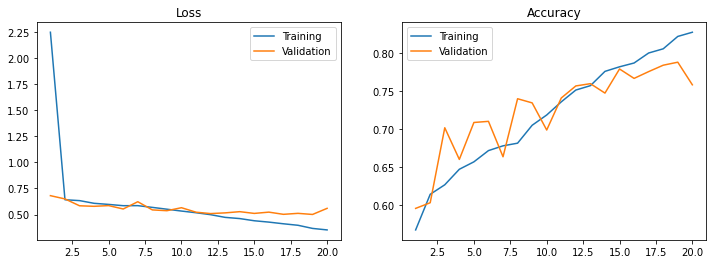

In [ ]:
plot_loss_acc(history,20)

#### 데이터 증강

* `horizontal_flip` : 좌우 방향 뒤집기
* `shear_range` : 이미지 반시계 방향 이동
* `zoom_range` : 이미지를 줌으로 확대

In [17]:
image_gen_aug = ImageDataGenerator(rescale = 1/255.,
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   shear_range = 0.15,
                                   zoom_range = 0.3)

#폴더에서 이미지 가져와서 제너레이터 객체로 정리

train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size = 32,
                                                  target_size = (224,224),
                                                  classes = ['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed = 2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir, batch_size = 32, target_size = (224,224),
                                                  classes = ['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed = 2020)

#모델 생성
model_aug = build_model()

#모델 컴파일
model_aug.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
                  loss =tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

#모델 훈련
history_aug = model_aug.fit(train_gen_aug,validation_data = valid_gen_aug, epochs = 10)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/10
251/251 [==============================] - 1128s 4s/step - loss: 1.8734 - accuracy: 0.5640 - val_loss: 0.6498 - val_accuracy: 0.6080
Epoch 2/10
251/251 [==============================] - 1116s 4s/step - loss: 0.6508 - accuracy: 0.6125 - val_loss: 0.6395 - val_accuracy: 0.6283
Epoch 3/10
251/251 [==============================] - 1119s 4s/step - loss: 0.6329 - accuracy: 0.6392 - val_loss: 0.6249 - val_accuracy: 0.6327
Epoch 4/10
251/251 [==============================] - 1111s 4s/step - loss: 0.6302 - accuracy: 0.6411 - val_loss: 0.6138 - val_accuracy: 0.6604
Epoch 5/10
251/251 [==============================] - 1106s 4s/step - loss: 0.6338 - accuracy: 0.6403 - val_loss: 0.6325 - val_accuracy: 0.6426
Epoch 6/10
251/251 [==============================] - 1093s 4s/step - loss: 0.6291 - accuracy: 0.6344 - val_loss: 0.6118 - val_accuracy: 0.6925
Epoch 7/10
251/251 [==============================] 

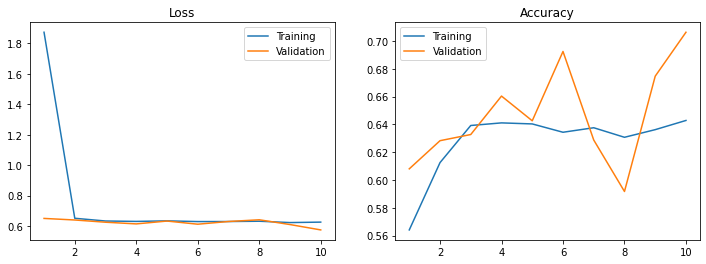

In [21]:
plot_loss_acc(history_aug,10)